In [1]:
#Importamos las librerias necesarias
import re
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as grb
from gurobipy import GRB
from timeit import timeit
from time import time

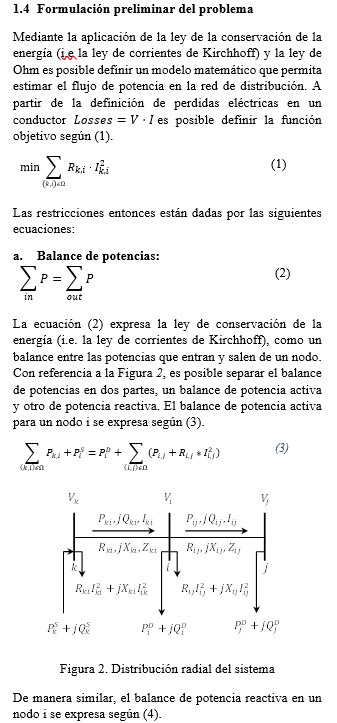

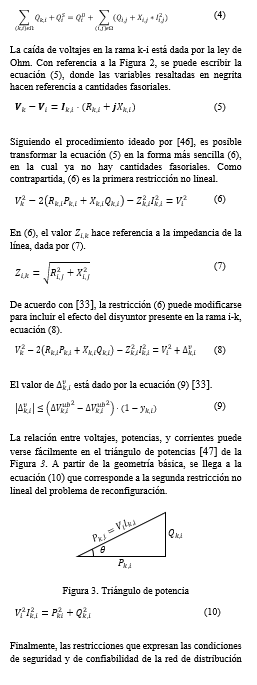

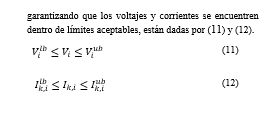

In [2]:
#Vamos creando aqui la clase
class DistributionNetwork():
    def __init__(self,ruta,b):
        start_reading=time()
        self.b=b#parametro de tunning restriccion cespedes.
        self.ruta=ruta
        file=open(self.ruta)#abre el archivo
        datos=file.readlines()#lee el contenido del archivo
        file.close()#cierra el archivo
        #Ahora determinamos los inicios y finales de las tablas de ramas y potencias:
        #primero declaramos algunas variables utiles:
        nodo_ref=0
        index_inicio_ramas=0
        index_final_ramas=0
        index_inicio_potencias=0
        index_final_potencias=0
        datos_ramas=[]
        datos_potencias=[]
        
        #determinamos el inicio y final de la tabla de ramas:
        for index, line in enumerate(datos):#Hallamos el inicio y el final de la tabla de datos de la red
            if line.startswith("ramos = ["):
                index_inicio_ramas=index
                print(index_inicio_ramas)
            if line.endswith("];\n"):
                index_final_ramas=index
                print(index_final_ramas)
                break
        #determinamos el inicio y final de la tabla de potencias:
        for index, line in enumerate(datos):#Hallamos el inicio y el final de la tabla de datos de potencia
            if line.startswith("barras"):
                index_inicio_potencias=index
                print(index_inicio_potencias)
            if (line.endswith("];\n")| line.endswith("];")) and index_inicio_potencias!=0:
                index_final_potencias=index
                print(index_final_potencias)
                break
        print(index_inicio_ramas)
        #Ahora si, extraemos todos los datos necesarios del archivo:
        for index, line in enumerate(datos):#itera sobre cada una de las lineas de datos
            if line.startswith("""% Datos globales"""):
                self.nodo_ref=int(re.findall('\d{1,3}',datos[index+1])[0])#almacena el atributo nodo de referencia
                self.v_ref=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+2])[0])#almacena el atributo voltaje de referencia
                self.v_base=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+3])[0])*1000#almacena el atributo voltaje base
                self.s_base=float(re.findall('\d+',datos[index+4])[0])*1000#almacena el atributo potencia aparente base
                self.tol=float(re.findall('\d{1,2}\^\-\d{1}',
                                          datos[index+5])[0][0:2])**float(re.findall('\d{1,2}\^\-\d{1}',
                                                                                    datos[index+5])[0][3:5])#almacena el atributo tolerancia
                #self.v_min=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+6])[0])#almacena el atributo voltaje minimo
                self.v_min=0
                
                #self.v_max=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+7])[0])#almacena el atributo voltaje_maximo
                self.v_max=1
                #self.v_max=1.5
                self.z_base=(self.v_base)**2/(self.s_base)#calcula la impedancia base a partir de la ley de ohm
                self.i_max=5
                #extraemos los datos de las ramas:
            if index>=index_inicio_ramas and index<=index_final_ramas:#extraemos los datos de las ramas
                nodos=re.findall("\d{1,3}",line)
                impedancia=re.findall("\d{1,3}\.\d{1,7}",line)
                datos_ramas.append([nodos[0],nodos[1],impedancia[0],impedancia[1]])
            #extrae los datos de las potencias
            if index>=index_inicio_potencias and index<=index_final_potencias:
                lista_re=re.findall("\d+\.*\d*",line)
                datos_potencias.append([lista_re[0],lista_re[1],lista_re[2],lista_re[3]])
            #creamos dos dataframes:
            #print(datos_ramas)
            self.ramas=pd.DataFrame(datos_ramas,columns=["nodo_i","nodo_j","R","X"])#creamos los dataframes de ramas y potencias
            self.potencias=pd.DataFrame(datos_potencias,columns=["nodo","Pd","Qd","Qbc"])
            #Ajustamos el tipo de dato de todas las columnas a ser float64
            self.potencias.nodo=self.potencias.nodo.astype("float")
            self.potencias.Pd=self.potencias.Pd.astype("float")*1000
            self.potencias.Qd=self.potencias.Qd.astype("float")*1000
            self.potencias.Qbc=self.potencias.Qbc.astype("float")*1000
            self.ramas.nodo_i= self.ramas.nodo_i.astype("float")
            self.ramas.nodo_j= self.ramas.nodo_j.astype("float")
            self.ramas.R= self.ramas.R.astype("float")
            self.ramas.X= self.ramas.X.astype("float")
            
            #Generamos a continuacion la red
        self.tiempo_leer_datos=time()-start_reading
        start_model_set_up=time()
        self.generar_red()
        #Generamos el modelo de gurobi
        self.generar_modelo_base()
        self.generar_variables_disyuntores()#Generemos la variable y_ij asociada al estado de los disyuntores
        self.generar_variables_potencia_ij()#Generamos la variable P_ij, asociada a la potencia activa de i a j
        self.generar_variable_Q_ij()#Generamos la variable Q_ij asociada a la potencia reactiva de i a j
        #self.generar_variables_V_i()#Generamos la vairable V_i, asociada al voltaje del nodo i
        self.generar_variables_Vsqr_i()#Generamos la variable Vsqr, asociada al cuadrado del voltaje del nodo i
        #self.generar_variables_I_ij()#Generamos la variable I_ij, asociada a la corriente del arco i,j
        self.generar_variables_I_sqr()#Genermos la variable I_ij_sqr asociada al cuadrado de la corriente del arco ij
        self.generar_variable_delta_ij()
        #A continuación generamos las restricciones del problema
        self.generar_restriccion_corrientes_sqr()
        self.generar_restriccion_un_solo_arco_ij()
        self.generar_restriccion_triangulo_potencia()
        self.generar_restriccion_delta()
        self.generar_restriccion_Ohm()
        self.balance_reactiva()
        self.balance_activa()
        #self.modelo.addConstr(self.voltajes_sqr[14]==1)#Fijamos el voltaje de la subestacion en 1 p.u
        #self.restriccion_auxiliar()
        #Actualizar el modelo
        self.modelo.update()
        #Escribir el reporte del modelo
        self.modelo.setParam('TimeLimit', 3600)
        self.set_up_time=time()-start_model_set_up
        self.generar_reporte()
        start_opt=time()
        #Optimizar
        self.optimizar()
        self.tiempo_opt=time()-start_opt
        self.tiempo_total=self.tiempo_leer_datos+self.tiempo_opt+self.set_up_time
    def generar_red(self):
        #En esta seccion generamos la red:
        self.Red=nx.DiGraph()#Creamos un elemento digraph
        #Recorremos primero la tabla de ramas:
        for element in self.ramas.itertuples():
            self.Red.add_edge(element[1],element[2])#añade el arco de i a j
            self.Red.add_edge(element[2],element[1])#añade el arco de j a i
            #Ahora añadimos la resistencia y la impedancia
            self.Red.edges[element[1],element[2]]["R"]=element[3]/self.z_base#*self.z_base#Añadimos la resistencia al arco ij
            self.Red.edges[element[1],element[2]]["X"]=element[4]/self.z_base#*self.z_base#Añadimos la inductancia al arco ij
            self.Red.edges[element[2],element[1]]["R"]=element[3]/self.z_base#*self.z_base#Añadimos la resistencia al arco ij
            self.Red.edges[element[2],element[1]]["X"]=element[4]/self.z_base#*self.z_base#Añadimos la inductancia al arco ij
        #Ahora recorremos la tabla de potencias
        for element in self.potencias.itertuples():
            self.Red.nodes[element[1]]["Pd"]=element[2]/self.s_base#Añadimos la demanda de potencia activa en el nodo
            self.Red.nodes[element[1]]["Qd"]=element[3]/self.s_base#Añadimos la demanda de potencia reactiva en el nodo
            self.Red.nodes[element[1]]["Qbc"]=element[4]/self.s_base#Añadimos el Qbc del nodo
    def graficar_red(self):
        nx.draw(self.Red, pos=nx.kamada_kawai_layout(self.Red),with_labels=True)
        plt.show()
    def generar_modelo_base(self):
        #Se crea un objeto modelo de gurobipy
        self.modelo=grb.Model(self.ruta[0:-4])
    def generar_variables_disyuntores(self):
        #En esta parte creamos la variable disyuntores 
        self.y=self.modelo.addVars(list(self.Red.edges),vtype=GRB.BINARY, name="estado_disyuntor",ub=1)
    def generar_variables_potencia_ij(self):
        self.pot=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="potencia_activa",lb=0,ub=5)
    def generar_variable_Q_ij(self):
        self.q=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="potencia_reactiva",lb=0,ub=5)
    def generar_variables_V_i(self):
        self.voltajes=self.modelo.addVars(list(self.Red.nodes),vtype=GRB.CONTINUOUS, name="voltaje",ub=self.v_max*self.v_base,
                                         lb=self.v_min*self.v_base)
    def generar_variables_Vsqr_i(self):
        self.voltajes_sqr=self.modelo.addVars(list(self.Red.nodes),vtype=GRB.CONTINUOUS, name="voltaje_sqr",
                                              lb=(self.v_min)**2,
                                              
                                              ub=(self.v_max)**2)
    def generar_variables_I_ij(self):
        self.corrientes=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="corriente",ub=self.i_max)
    def generar_variables_I_sqr(self):
        lista_resistencias=[element[2]["R"] for element in self.Red.edges.data()]#Generamos una lista con las resistencias de los arcos
        self.corrientes_sqr=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="corriente_sqr",
                                                obj=lista_resistencias,lb=0,ub=self.i_max**2)
    def generar_variable_delta_ij(self):
        b_abs=abs(self.v_max-self.v_min)
        self.delta=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS,name="delta",lb=-b_abs,ub=b_abs)
    def generar_reporte(self):
        self.modelo.write("reporte.lp")
        print("model written!!")
    def generar_restriccion_corrientes_sqr(self):
        #Esta función genera la restricción I_sqr<=I_ij**2
        for row in self.ramas.itertuples():#iteramos sobre el dataframe de ramas
            nodo_i=row[1]
            nodo_j=row[2]
            self.modelo.addConstr(self.corrientes_sqr[(nodo_i,nodo_j)]<=self.y[(nodo_i,nodo_j)]*self.i_max**2)#Restriccion del
            #arco ij
            self.modelo.addConstr(self.corrientes_sqr[(nodo_j,nodo_i)]<=self.y[(nodo_j,nodo_i)]*self.i_max**2)#Restriccion del
            #arco ij
    def generar_restriccion_un_solo_arco_ij(self):
        #Esta funcion genera la restriccion y_ij+y_ji=1
      
        #self.modelo.addConstr(grb.quicksum(self.y[edge] for edge in self.Red.edges())==len(self.Red.nodes())-1)
        for nodo in self.Red.nodes:
            if nodo!=self.nodo_ref:
                
                self.modelo.addConstr(self.y.sum('*',nodo)==1)
               
            else:
                self.modelo.addConstr(self.y.sum(nodo,'*')>=1)
        
            
    def generar_restriccion_triangulo_potencia(self):#Genera la restriccion P**2+Q**2=S**2
        for edge in self.Red.edges():
            nodo_j=edge[1]
            self.modelo.addConstr(self.voltajes_sqr[nodo_j]*self.corrientes_sqr[edge]>=(self.pot[edge])**2+(self.q[edge])**2)
    def generar_restriccion_delta(self):
        for edge in self.Red.edges():
            self.modelo.addConstr(self.b*(1-self.y[edge])>=self.delta[edge])#b*(1-y_ij)>=delta_ij
            self.modelo.addConstr(-self.b*(1-self.y[edge])<=self.delta[edge])#delta_ij>=-b*(1-y_ij)
    def generar_restriccion_Ohm(self):#Genera la restriccion de cespedes
        for edge in self.Red.edges():#Recorremos cada rama
            #Añadimos la restricción de cespedes
            nodo_i=edge[0]
            nodo_j=edge[1]
            R=self.Red.edges[edge]["R"]#Obtenemos la resistencia del arco ij
            X=self.Red.edges[edge]["X"]#Obtenemos la resistencia del arco ij
            Z_sqr=R**2+X**2#Clculamos la magnitud de la impedancia al cuadrado del arco ij
            self.modelo.addConstr(self.voltajes_sqr[nodo_i]==self.voltajes_sqr[nodo_j]+
                                  2*(R*self.pot[edge]+X*self.q[edge])-Z_sqr*self.corrientes_sqr[edge]+self.delta[edge])
    def balance_reactiva(self):#Genera la restriccion de balance de potencia reactiva
        for node in self.Red.nodes():#Iteramos sobre los nodos de la red
            if node!=self.nodo_ref:
                #Aplica para todos los nodos excepto el de referencia
                my_dict={(node,i):self.Red.edges[(node,i)]["X"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coeff = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.q.sum('*',node)-self.q.sum(node,'*')-self.corrientes_sqr.prod(coeff,node,'*')==
                                      self.Red.nodes[node]["Qd"])#Creamos la restriccion de balance de potencia reactiva
            else:#Este caso solo aplica para los nodos subestación
                my_dict={(node,i):self.Red.edges[(node,i)]["X"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coeff = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.q.sum('*',node)-self.q.sum(node,'*')-self.corrientes_sqr.prod(coeff,node,'*')<=
                                      -sum(self.potencias.Qd)/self.s_base)#Creamos la restriccion de balance de potencia reactiva
    def balance_activa(self):#Genera la restriccion de balance de potencia activa
        for node in self.Red.nodes():#Iteramos sobre los nodos de la red
            if node!=self.nodo_ref:#esta condición aplica para todos los nodos que no son subestacion
                my_dict={(node,i):self.Red.edges[(node,i)]["R"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coef = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.pot.sum('*',node)-self.pot.sum(node,'*')-self.corrientes_sqr.prod(coef,node,'*')==
                                    self.Red.nodes[node]["Pd"])#Añade la restricción de flujo de activa
            else:#Este caso solo aplica para los nodos subestacion
                my_dict={(node,i):self.Red.edges[(node,i)]["R"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coef = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.pot.sum('*',node)-self.pot.sum(node,'*')-self.corrientes_sqr.prod(coef,node,'*')<=
                                    -sum(self.potencias.Pd)/self.s_base)
    def restriccion_auxiliar(self):#Esta no sirvio!
        for node in self.Red.nodes():#Iteramos sobre los nodos
            if node!=self.nodo_ref:#Para todos los nodos esxcepto el de referencia
                self.modelo.addConstr(self.y.sum('*',node)==1)
                R=self.Red.predecessors(node)
                #maxVarsList=[self.y[node,element] for elemen in R]
                #self.modelo.addGenConstrMax(1, maxVarsList, name='maxconstr_')
                #"self.modelo.addConstr(1==grb.max_(self.y[element,node] for element in R))
                self.modelo.addConstr((self.y.sum('*',node))**2-2*self.y.sum('*',node)<=-1)
                #R=self.Red.predecessors(node)
                #self.modelo.addConstr(grb.quicksum(self.y[r,node]**2 for r in R)<=1)
            else:#el nodo ref
                #self.modelo.addConstr(self.y.sum(node,'*')==3)
                pass
    def optimizar(self):
        #self.modelo.params.NonConvex = 2
        start=time()
        self.modelo.optimize()
        self.tiempo_computo=time()-start
        if self.modelo.Status == grb.GRB.INFEASIBLE:
            self.modelo.computeIIS()
            self.modelo.write('iismodel.ilp')
    def get_red_opti(self):
        self.red_optima=nx.Graph()
        for element in self.y:
            if round(self.y[element].x)==1:
                self.red_optima.add_edge(element[0],element[1])
        nx.draw(self.red_optima, pos=nx.kamada_kawai_layout(self.red_optima),with_labels=True)
        plt.show()
                
    
                
            
       
            
    
    
        
    
        
            
            
        
            
        


In [3]:
red_33=DistributionNetwork("datos417.txt",0.2)

16
488
492
906
16
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-14
Set parameter TimeLimit to value 3600
model written!!
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 3550H with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5029 rows, 5145 columns and 17974 nonzeros
Model fingerprint: 0x959d15c9
Model has 946 quadratic constraints
Variable types: 4199 continuous, 946 integer (946 binary)
Coefficient statistics:
  Matrix range     [2e-06, 3e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e-03, 6e-01]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e-06, 1e+00]
Presolve removed 686 rows and 527 columns
Presolve time: 0.06s
Presolved: 4343 rows, 4618 columns, 16635 nonzeros
Presolved model has 932 quadratic constraint(s)
Variable types: 4068 continuous, 550 integer (550 binary)

Root rel

 33074 22908    0.00657   63  109          -    0.00488      -  47.7  293s
 33957 23477    0.00588   22  131          -    0.00488      -  47.7  301s
 34664 24131    0.00806   45  107          -    0.00488      -  48.1  318s
 35677 24562    0.01049  124   28          -    0.00488      -  48.6  339s
 36268 25248    0.00516   18  151          -    0.00488      -  49.6  358s
 37269 25770    0.00955   45  124          -    0.00488      -  50.0  387s
 38081 26388    0.01253  137   31          -    0.00489      -  50.0  411s
 39014 27110    0.00565   28  123          -    0.00490      -  50.8  421s
 40003 27926    0.00779   86   60          -    0.00490      -  51.0  433s
 41236 28694    0.00572   36  136          -    0.00491      -  50.9  452s
 42290 29244    0.00607   29  137          -    0.00491      -  51.3  469s
 43018 29866    0.00888   99   40          -    0.00492      -  51.9  481s
 43985 30621    0.00569   25  134          -    0.00492      -  52.2  492s
 44959 31185 infeasible  

 124567 81422    0.00566   29  150    0.01653    0.00519  68.6%  73.1 2846s
 125585 82064    0.00535   21  181    0.01653    0.00519  68.6%  73.2 2873s
 126365 82531    0.00799  100   52    0.01653    0.00519  68.6%  73.3 2906s
 127000 83403    0.00996   59   98    0.01653    0.00519  68.6%  73.5 2935s
 128215 84117    0.01004   94   59    0.01653    0.00519  68.6%  73.4 2963s
 129223 84539 infeasible   49         0.01653    0.00519  68.6%  73.4 2992s
 129747 85171    0.01192   99   66    0.01653    0.00519  68.6%  73.7 3021s
 130661 85841    0.00584   16  172    0.01653    0.00520  68.6%  73.8 3060s
 131596 86294 infeasible  144         0.01653    0.00520  68.6%  73.9 3087s
 132231 86531 infeasible   34         0.01653    0.00520  68.6%  74.0 3111s
 132524 86973    0.00597   45  115    0.01653    0.00520  68.6%  74.3 3143s
 133087 87693    0.00739   73   86    0.01653    0.00520  68.6%  74.6 3172s
 134071 88152    0.01188  132    -    0.01653    0.00520  68.5%  74.7 3199s
 134687 8876

In [4]:
red_33.z_base

1.0

In [5]:
red_33.s_base

100000000.0

In [6]:
red_33.tiempo_leer_datos

5.801422357559204

In [7]:
red_33.set_up_time

0.9452118873596191

In [8]:
red_33.tiempo_computo

3600.504426717758

In [9]:
red_33.tiempo_total

3607.251060962677

In [13]:
def disyuntores():
    my_string=""
    for v in red_33.modelo.getVars():
        if v.x>0.5:
            print("entro1")
            if v.varName.startswith("estado"):
                print("entro2")
                nodo_i=re.findall('\[(\d+)',v.varName)[0]
                nodo_j=re.findall('(\d+)\.\d]',v.varName)[0]
                my_string=my_string+"({}-{}), ".format(nodo_i,nodo_j)
    print(my_string)
            

In [14]:
disyuntores()

entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1
entro2
entro1

In [10]:
for v in red_33.modelo.getVars():
    if v.x>1e-6:
        print(v.varName,v.x)

estado_disyuntor[68.0,93.0] 1.0
estado_disyuntor[68.0,67.0] 1.0
estado_disyuntor[89.0,88.0] 1.0
estado_disyuntor[67.0,89.0] 1.0
estado_disyuntor[67.0,64.0] 1.0
estado_disyuntor[225.0,224.0] 1.0
estado_disyuntor[224.0,222.0] 1.0
estado_disyuntor[21.0,47.0] 1.0
estado_disyuntor[21.0,50.0] 1.0
estado_disyuntor[21.0,49.0] 1.0
estado_disyuntor[21.0,57.0] 1.0
estado_disyuntor[72.0,21.0] 1.0
estado_disyuntor[72.0,74.0] 1.0
estado_disyuntor[66.0,252.0] 1.0
estado_disyuntor[3.0,20.0] 1.0
estado_disyuntor[3.0,9.0] 1.0
estado_disyuntor[20.0,44.0] 1.0
estado_disyuntor[20.0,33.0] 1.0
estado_disyuntor[222.0,221.0] 1.0
estado_disyuntor[74.0,75.0] 1.0
estado_disyuntor[382.0,70.0] 1.0
estado_disyuntor[382.0,66.0] 1.0
estado_disyuntor[51.0,52.0] 1.0
estado_disyuntor[221.0,344.0] 1.0
estado_disyuntor[52.0,56.0] 1.0
estado_disyuntor[220.0,223.0] 1.0
estado_disyuntor[75.0,81.0] 1.0
estado_disyuntor[81.0,76.0] 1.0
estado_disyuntor[59.0,77.0] 1.0
estado_disyuntor[56.0,27.0] 1.0
estado_disyuntor[1.0,273.0] 1.

potencia_activa[45.0,49.0] 1.0711623087907958e-05
potencia_activa[281.0,280.0] 5.467334450599316e-06
potencia_activa[281.0,235.0] 5.4340071087135456e-06
potencia_activa[281.0,282.0] 6.15381156416429e-06
potencia_activa[119.0,121.0] 0.0007900000000002905
potencia_activa[119.0,94.0] 4.187224220971287e-06
potencia_activa[119.0,122.0] 0.002473584135360673
potencia_activa[119.0,200.0] 0.0005242825917529093
potencia_activa[49.0,21.0] 6.313618442999234e-06
potencia_activa[235.0,281.0] 6.488891134436157e-06
potencia_activa[235.0,234.0] 0.00931230514793734
potencia_activa[235.0,236.0] 5.600941174684094e-06
potencia_activa[14.0,2.0] 5.557525197680642e-06
potencia_activa[14.0,16.0] 0.001132337200312038
potencia_activa[55.0,23.0] 0.003226417032034211
potencia_activa[55.0,33.0] 5.49247600976544e-06
potencia_activa[23.0,55.0] 5.443752007399718e-06
potencia_activa[23.0,28.0] 0.00245504565131801
potencia_activa[282.0,281.0] 6.2077593281678675e-06
potencia_activa[282.0,283.0] 0.0012515951410248306
pote

potencia_activa[334.0,335.0] 0.0012599999999998168
potencia_activa[334.0,333.0] 5.056625506765676e-06
potencia_activa[336.0,334.0] 5.673050159031424e-06
potencia_activa[336.0,337.0] 1.0705304634485074e-05
potencia_activa[283.0,257.0] 1.5957150814271172e-06
potencia_activa[283.0,282.0] 5.224098050408777e-06
potencia_activa[323.0,336.0] 7.831969620187814e-06
potencia_activa[323.0,324.0] 5.484537411577659e-06
potencia_activa[323.0,322.0] 7.029388085482264e-06
potencia_activa[327.0,268.0] 9.518656973283136e-06
potencia_activa[327.0,328.0] 0.0015499999999990521
potencia_activa[337.0,338.0] 5.248628879297925e-06
potencia_activa[338.0,337.0] 0.0007992872043351188
potencia_activa[338.0,339.0] 5.218511874480857e-06
potencia_activa[322.0,323.0] 3.868981348590385e-06
potencia_activa[322.0,321.0] 4.725138356535229e-06
potencia_activa[322.0,329.0] 0.008986908357495748
potencia_activa[233.0,234.0] 6.0604628050252775e-06
potencia_activa[233.0,376.0] 0.005207225271171004
potencia_activa[297.0,268.0] 6

potencia_reactiva[310.0,306.0] 0.0012257968839671607
potencia_reactiva[310.0,320.0] 0.00021000000000048757
potencia_reactiva[310.0,314.0] 5.40612579695613e-06
potencia_reactiva[315.0,310.0] 5.6271852858899114e-06
potencia_reactiva[315.0,318.0] 5.62539350254612e-06
potencia_reactiva[315.0,311.0] 3.967248158295807e-06
potencia_reactiva[126.0,124.0] 7.100596225640849e-06
potencia_reactiva[124.0,126.0] 1.6514115086181318e-06
potencia_reactiva[124.0,127.0] 1.0152303073592002e-05
potencia_reactiva[98.0,94.0] 5.737173924973359e-06
potencia_reactiva[98.0,116.0] 0.00442030994455337
potencia_reactiva[160.0,180.0] 0.0015470383063553048
potencia_reactiva[160.0,181.0] 5.920691398060778e-06
potencia_reactiva[160.0,129.0] 1.0665949593223353e-05
potencia_reactiva[160.0,179.0] 3.0493243063063964e-06
potencia_reactiva[180.0,160.0] 5.488486825399256e-06
potencia_reactiva[180.0,177.0] 0.0005899999999997574
potencia_reactiva[180.0,174.0] 0.0005890491498413364
potencia_reactiva[351.0,1.0] 5.797197616011818e

voltaje_sqr[308.0] 0.9713416249402365
voltaje_sqr[361.0] 0.9871106564886283
voltaje_sqr[272.0] 0.9942593272301679
voltaje_sqr[316.0] 0.9735755023741661
voltaje_sqr[296.0] 0.9461569136595633
voltaje_sqr[260.0] 0.9452865356211428
voltaje_sqr[256.0] 0.9870910644049825
voltaje_sqr[312.0] 0.9736334098354973
voltaje_sqr[287.0] 0.9451843935366094
voltaje_sqr[255.0] 0.9871194883888145
voltaje_sqr[364.0] 0.9828133196427133
voltaje_sqr[324.0] 0.9235512520144769
voltaje_sqr[284.0] 0.9827529598332668
voltaje_sqr[326.0] 0.9235309964090497
voltaje_sqr[258.0] 0.9873409631880127
voltaje_sqr[334.0] 0.9375578702891914
voltaje_sqr[336.0] 0.9367897616075235
voltaje_sqr[283.0] 0.9810738850548033
voltaje_sqr[323.0] 0.9367893451821756
voltaje_sqr[325.0] 0.9235198442772812
voltaje_sqr[327.0] 0.9520688027148254
voltaje_sqr[337.0] 0.9115574099425902
voltaje_sqr[328.0] 0.9518363865587349
voltaje_sqr[338.0] 0.9116194512257846
voltaje_sqr[322.0] 0.9401340542372225
voltaje_sqr[233.0] 0.9810662127134565
voltaje_sqr[

In [17]:
red_33.tiempo_computo

0.6490488052368164

In [18]:
red_33.modelo.tune()


Solving model using baseline parameter set with TimeLimit=3600s

Testing candidate parameter set 1...

	Default parameters

Solving with random seed #1 ...
Optimize a model with 395 rows, 403 columns and 1406 nonzeros
Model fingerprint: 0xf6fe7376
Model has 74 quadratic constraints
Variable types: 329 continuous, 74 integer (74 binary)
Coefficient statistics:
  Matrix range     [4e-05, 3e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [6e-03, 1e-01]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e-03, 1e+00]
Presolve removed 45 rows and 45 columns
Presolve time: 0.01s
Presolved: 350 rows, 358 columns, 1304 nonzeros
Presolved model has 71 quadratic constraint(s)
Variable types: 319 continuous, 39 integer (39 binary)

Root relaxation: objective 4.405513e-04, 71 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    

     0     0    0.00215    0   16          -    0.00215      -     -    0s
     0     0    0.00243    0   15          -    0.00243      -     -    0s
     0     0    0.00545    0   23          -    0.00545      -     -    0s
     0     0    0.00625    0   20          -    0.00625      -     -    0s
     0     0    0.00938    0   23          -    0.00938      -     -    0s
     0     0    0.00967    0   24          -    0.00967      -     -    0s
     0     0    0.01075    0   25          -    0.01075      -     -    0s
     0     0    0.01100    0   26          -    0.01100      -     -    0s
     0     0    0.01143    0   23          -    0.01143      -     -    0s
     0     0    0.01164    0   24          -    0.01164      -     -    0s
     0     0    0.01172    0   21          -    0.01172      -     -    0s
     0     0    0.01176    0   22          -    0.01176      -     -    0s
     0     0    0.01185    0   24          -    0.01185      -     -    0s
     0     0    0.01188  

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\pablo\anaconda3\lib\site-packages\ipykernel\iostream.py", line 404, in write
    self.pub_thread.schedule(lambda : self._buffer.write(string))
  File "C:\Users\pablo\anaconda3\lib\site-packages\ipykernel\iostream.py", line 205, in schedule
    self._event_pipe.send(b'')
  File "C:\Users\pablo\anaconda3\lib\site-packages\zmq\sugar\socket.py", line 491, in send
    return super(Socket, self).send(data, flags=flags, copy=copy, track=track)
  File "zmq/backend/cython/socket.pyx", line 720, in zmq.backend.cython.socket.Socket.send
  File "zmq/backend/cython/socket.pyx", line 767, in zmq.backend.cython.socket.Socket.send
  File "zmq/backend/cython/socket.pyx", line 242, in zmq.backend.cython.socket._send_copy
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
    PyErr_CheckSignals()
KeyboardInterrupt: 



Progress so far:
  baseline: mean runtime 0.60s
  best:     mean runtime 0.42s
Total elapsed tuning time 15s (3s remaining)

-------------------------------------------------------------------------------

Testing candidate parameter set 13 ...

	Method 0

Solving with random seed #1 ... runtime 0.43s
Solving with random seed #2 ... runtime 0.53s
Solving with random seed #3 ... runtime 0.57s+

Progress so far:
  baseline: mean runtime 0.60s
  best:     mean runtime 0.42s
Total elapsed tuning time 16s (2s remaining)

-------------------------------------------------------------------------------

Testing candidate parameter set 14 ...

	CutPasses 1

Solving with random seed #1 ... runtime 0.45s
Solving with random seed #2 ... runtime 0.57s
Solving with random seed #3 ... runtime 0.41s+

Progress so far:
  baseline: mean runtime 0.60s
  best:     mean runtime 0.42s
Total elapsed tuning time 18s (0s remaining)

-----------------------------------------------------------------------------

In [19]:
red_33.modelo.getTuneResult(0)

In [20]:
red_33.modelo.write("ensayo.prm")

In [21]:
G=red_33.Red.to_undirected()

In [22]:
G.edges

EdgeView([(1.0, 2.0), (2.0, 3.0), (2.0, 19.0), (3.0, 4.0), (3.0, 23.0), (4.0, 5.0), (5.0, 6.0), (6.0, 7.0), (6.0, 26.0), (7.0, 8.0), (8.0, 9.0), (8.0, 21.0), (9.0, 10.0), (9.0, 15.0), (10.0, 11.0), (11.0, 12.0), (12.0, 13.0), (12.0, 22.0), (13.0, 14.0), (14.0, 15.0), (15.0, 16.0), (16.0, 17.0), (17.0, 18.0), (18.0, 33.0), (19.0, 20.0), (20.0, 21.0), (21.0, 22.0), (23.0, 24.0), (24.0, 25.0), (25.0, 29.0), (26.0, 27.0), (27.0, 28.0), (28.0, 29.0), (29.0, 30.0), (30.0, 31.0), (31.0, 32.0), (32.0, 33.0)])

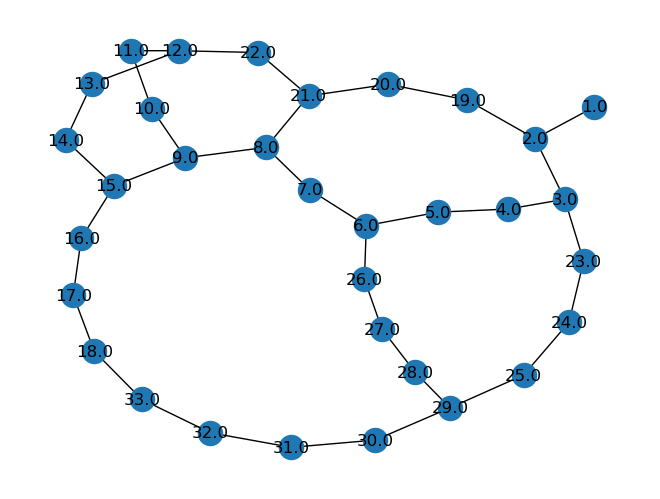

In [23]:
nx.draw(G, pos=nx.kamada_kawai_layout(G),with_labels=True)
plt.show()